# EXPLORE THE DATA

In [212]:
#library import
import time
import pandas as pd
import geohash2
import xgboost as xgb
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

In [290]:
data = pd.read_csv('training.csv')
df = data
df.head(5)

,geohash6,day,timestamp,demand
0,qp03wc,18,20:0,0.020072
1,qp03pn,10,14:30,0.024721
2,qp09sw,9,6:15,0.102821
3,qp0991,32,5:0,0.088755
4,qp090q,15,4:0,0.074468


FUNCTION DEFINITION

In [289]:
def data_cleaning(df):
    '''
    This is a function to clean first dataframe by decoding geohash => exactly longtitude and latitude and convert time to 
    date time for plotting purpose.
    
    Returns: 
    Dataframe with features
    '''
    df['latitude'] = df['geohash6'].apply(lambda x:geohash2.decode_exactly(x)[0])
    df['longtitude'] = df['geohash6'].apply(lambda x:geohash2.decode_exactly(x)[1])
    df['time'] = [time.time() for time in pd.to_datetime(df['timestamp'],format='%H:%M')]
    return df
def plot_data_with_demand(day_start,day_finish,element,df):
    '''
    A method to plot observed data by day
    element: can be longtitude, latitude or time
    '''
    plt.figure(figsize=(20,10))
    for i in range(day_start,day_finish+1):
        df_day = df[df['day']==i]
        plt.plot(df_day[[element,'demand']].groupby(element).mean(),label='day: '+str(i))
    plt.title('Relation between '+element+' and demand',fontsize=20)
    plt.xlabel('Distinct '+element,fontsize=15)
    plt.ylabel('Average demand',fontsize=15)
    if (day_finish-day_start) < 5:
        plt.legend(loc='upper left',fontsize=15)
    plt.show()
def data_for_training(df,test_size_param,random_state_param,predict_check):
    '''
    Method to prepare data before XGBoost training: label encoder 
    '''
    if predict_check == False:
        df['mean_demand'] = df.groupby('day')['demand'].transform('mean')
    clean_df = df.drop(['geohash6','timestamp','day'],axis=1)
    for f in clean_df.columns:
        if clean_df[f].dtype == 'object':
            label = LabelEncoder()
            label.fit(list(clean_df[f].values))
            clean_df[f] = label.transform(list(clean_df[f].values))
    if predict_check:
        return clean_df
    X = clean_df.drop(['demand'],axis=1)
    y = clean_df['demand']
    return train_test_split(X,y,test_size=test_size_param,random_state=random_state_param)
def training_process(xgboost_params,X_train,X_test,y_train,y_test):
    model = xgb.XGBRegressor(**xgboost_params)
    model.fit(X_train.values,y_train.values)
    y_predict = model.predict(X_test.values)
    print("Mean squared error of test set: \n",mean_squared_error(y_test.values,y_predict))
    print("Model score on test set: \n",model.score(X_test.values,y_test))
    y_predict = model.predict(X_train.values)
    print("Mean squared error of training set: \n",mean_squared_error(y_train.values,y_predict))
    print("Model score on training set: \n",model.score(X_train.values,y_train))
    return model
def average_demand_prediction(df,train_start_day,train_end_day,predict_start_day,predict_end_day,order_param,seasonal_param):
    '''
    A method to predict future mean_deamnd - average demand in a day
    
    Return: series with index is day
    '''
    df2 = pd.DataFrame(df.groupby('day')['demand'].mean())
    model = SARIMAX(df2[train_start_day-1:train_end_day],order=order_param,seasonal_order=seasonal_param,enforce_stationarity=False)
    result = model.fit()
    plt.figure(figsize=(20,10))
    data = result.predict(start=predict_start_day,end=predict_end_day,dynamic=False)
    plt.plot(data,label='Predicted average demand values')
    plt.plot(df2[train_start_day-1:train_end_day])
    plt.show()
    return data
def predict_future_demand(test_dataset,model,data):
    temp_test = test_dataset
    temp_test['mean_demand'] = temp_test['day'].apply(lambda x:data.get_value(x))
    temp_test = data_cleaning(temp_test)
    temp_test = data_for_training(temp_test,0.3,42,predict_check=True)
    temp_test['predict_demand'] = model.predict(temp_test[['latitude','longtitude','time','mean_demand']].values)
    temp_test = temp_test.drop(['latitude','longtitude','time','mean_demand'],axis=1)
    temp_test = test_dataset[['geohash6','day','timestamp']].join(temp_test)
    return temp_test

In [191]:
clean_df = data_cleaning(df)
clean_df.head(5)

,geohash6,day,timestamp,demand,latitude,longtitude,time
0,qp03wc,18,20:0,0.020072,-5.353088,90.653687,20:00:00
1,qp03pn,10,14:30,0.024721,-5.413513,90.664673,14:30:00
2,qp09sw,9,6:15,0.102821,-5.325623,90.906372,06:15:00
3,qp0991,32,5:0,0.088755,-5.353088,90.752563,05:00:00
4,qp090q,15,4:0,0.074468,-5.413513,90.719604,04:00:00


We have all we need after this step. Now I will plot some relation of the data we have. 

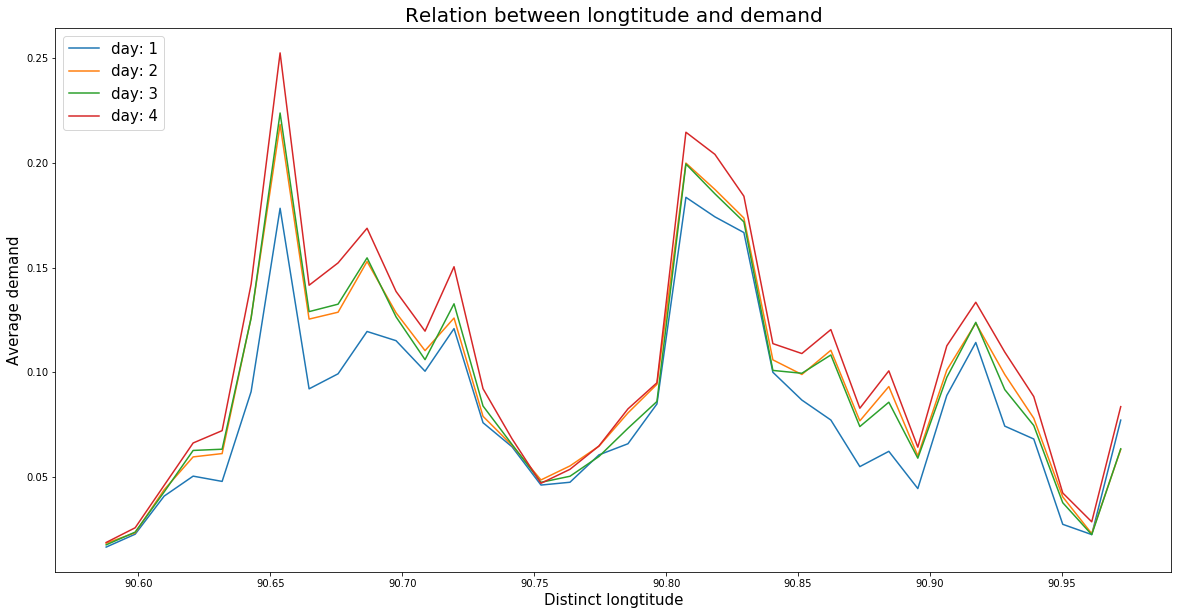

In [215]:
plot_data_with_demand(1,4,'longtitude',clean_df)

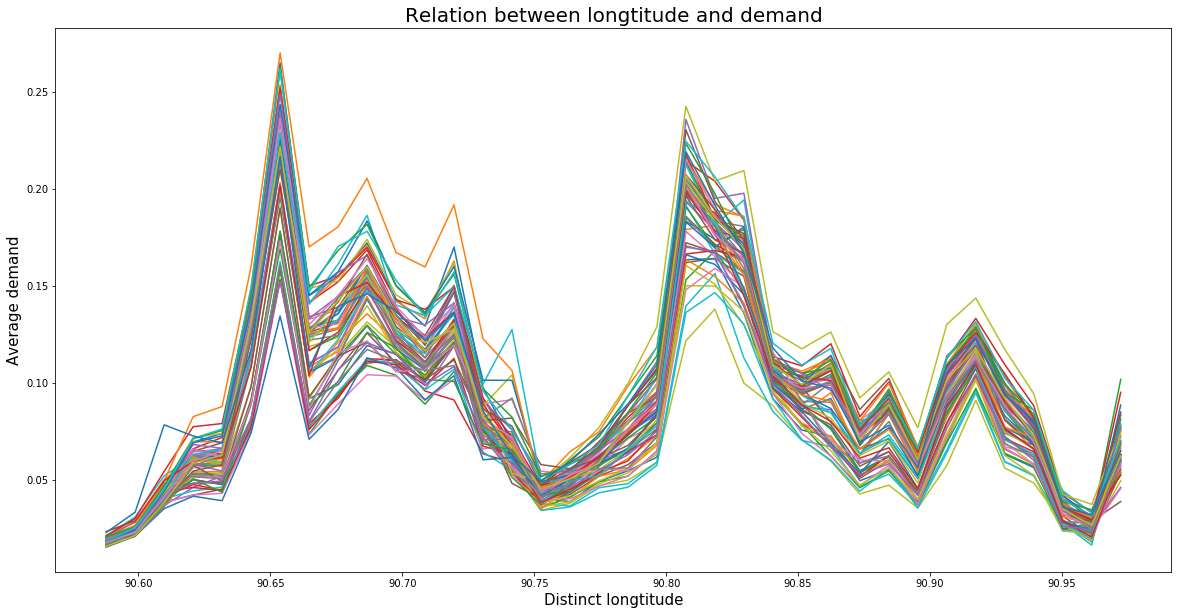

In [216]:
plot_data_with_demand(1,61,'longtitude',clean_df)

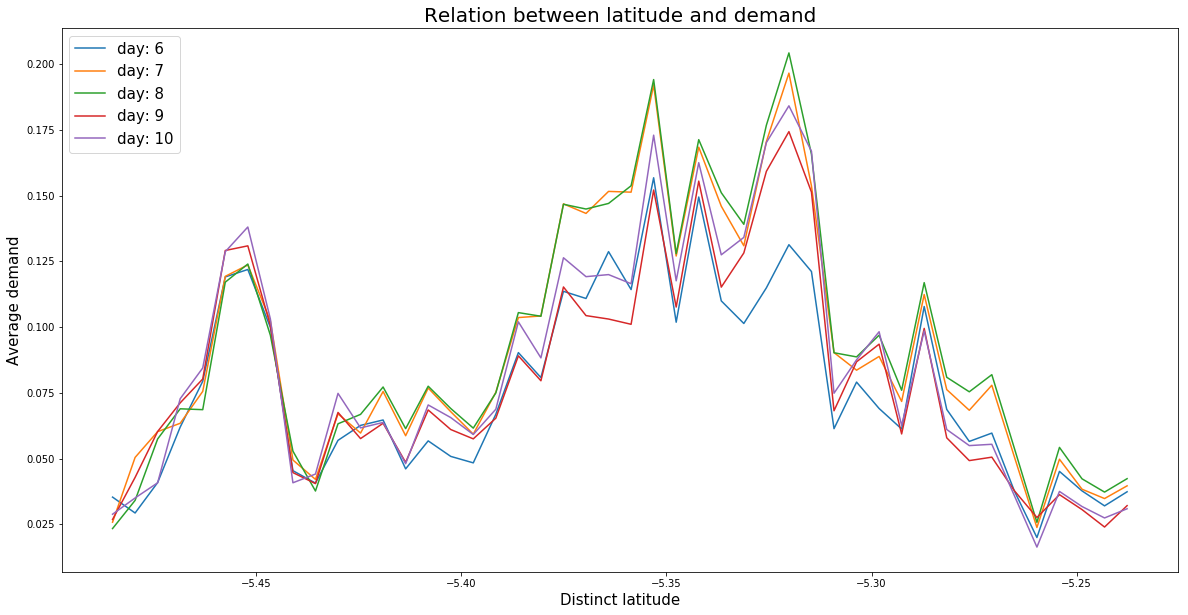

In [219]:
plot_data_with_demand(6,10,'latitude',clean_df)

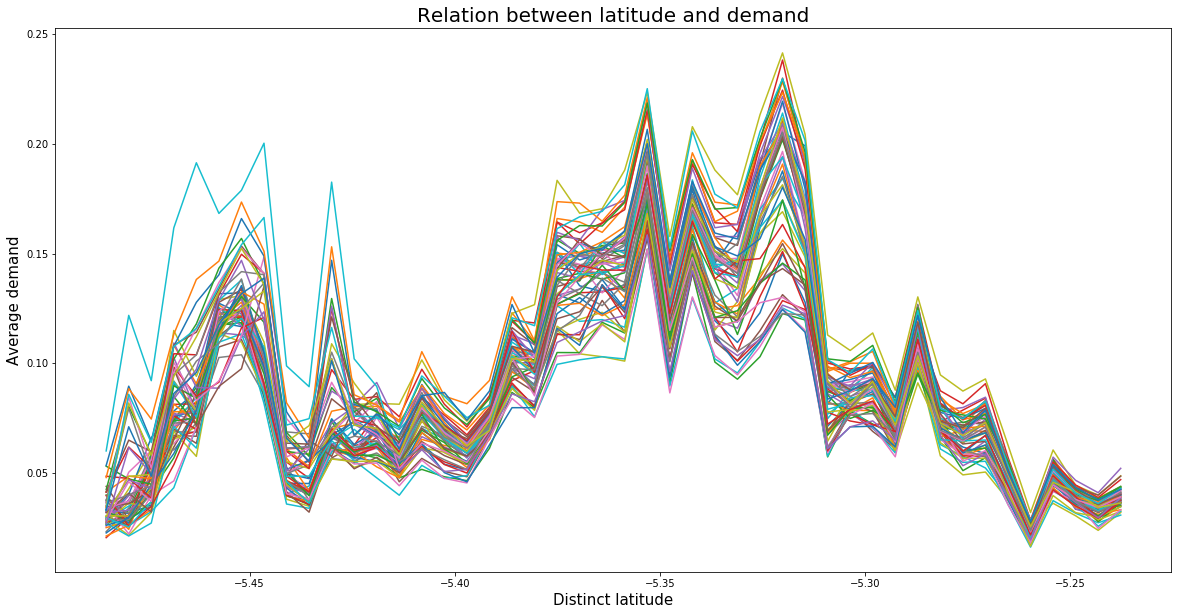

In [218]:
plot_data_with_demand(1,61,'latitude',clean_df)

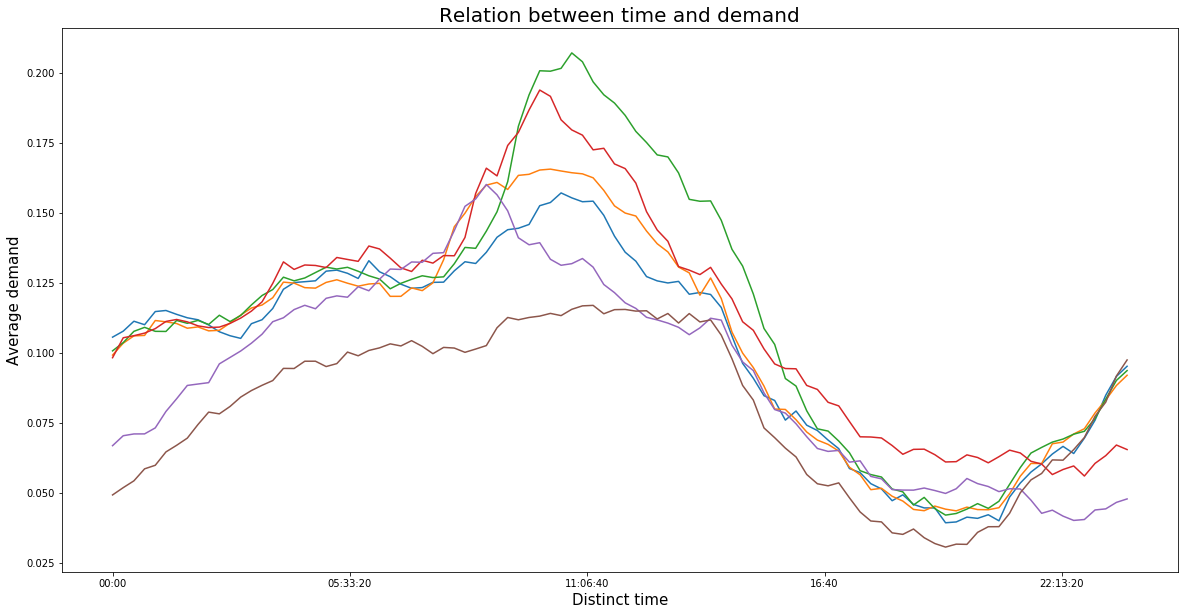

In [220]:
plot_data_with_demand(50,55,'time',clean_df)

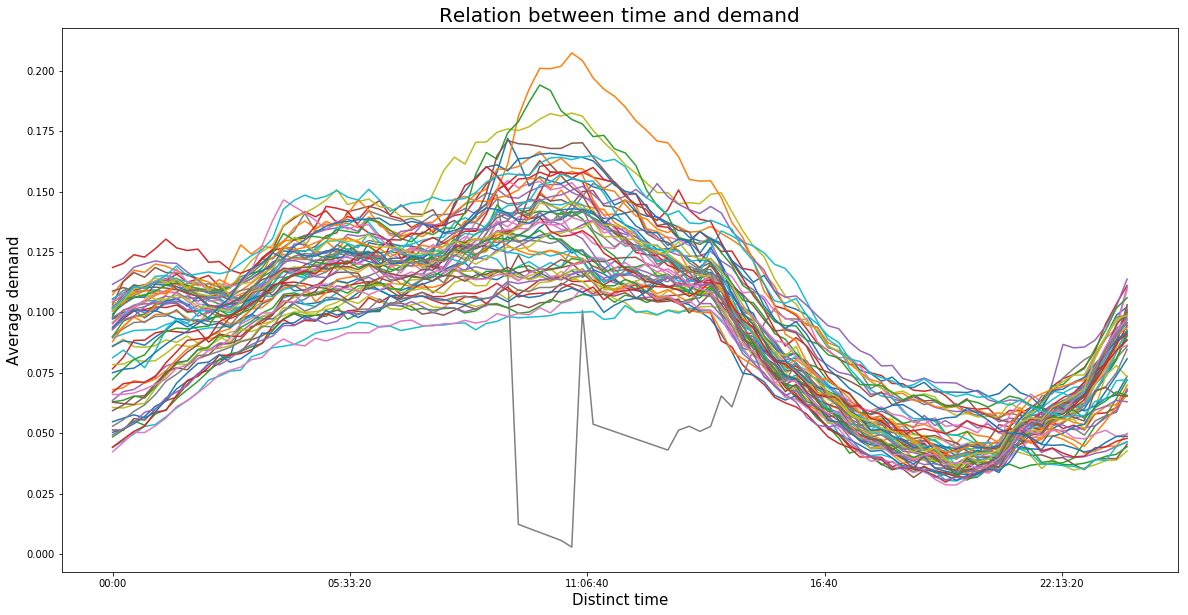

In [221]:
plot_data_with_demand(1,61,'time',clean_df)

# Conclusion 1

Longtitude, latitude and time are the first 3 features which impacted the whole demand we observer in 61 days. We can see the variance between each day but the parttern is very sharp here. It motivates me to plot the trend of demand on a time manner. 

[]

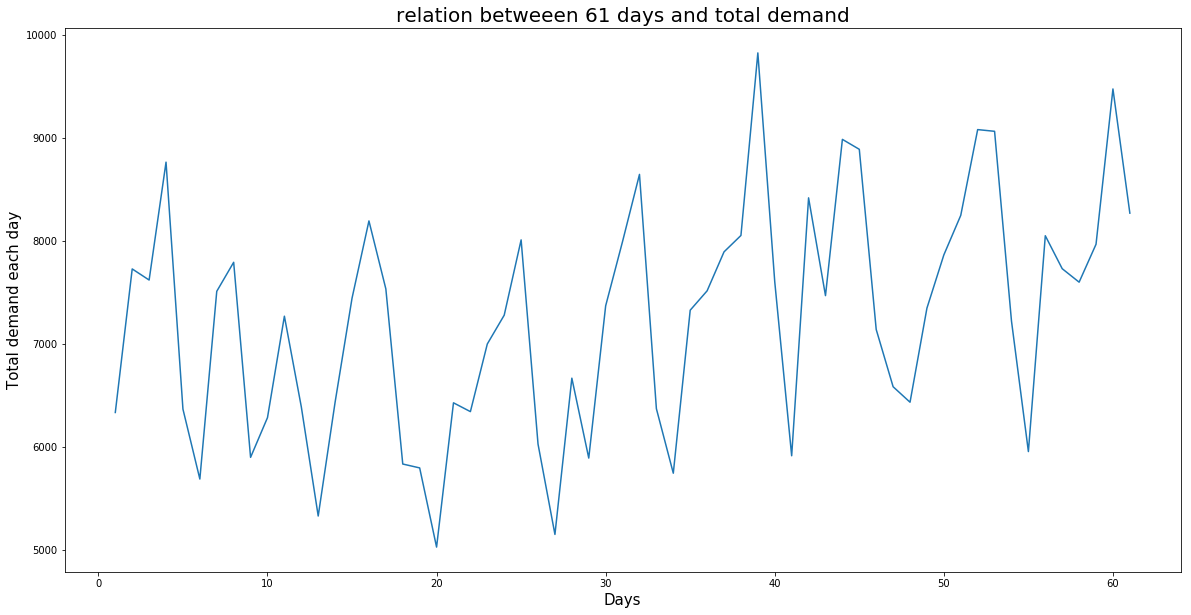

In [223]:
plt.figure(figsize=(20,10))
plt.plot(df[['demand','day']].groupby('day').sum())
plt.title('relation betweeen 61 days and total demand',fontsize=20)
plt.xlabel('Days',fontsize=15)
plt.ylabel('Total demand each day',fontsize=15)
plt.plot()

# Conclusion 2

This chart makes me pursuit a time series approach for this dataset. If we can predict average demand in consecutive days, we can make a regression model to get the demand in the future. I came to 3 libraries and 1 time series approach:

# TRAINING MODEL

In [229]:
X_train,X_test,y_train,y_test = data_for_training(clean_df,test_size_param=0.2,random_state_param=42,predict_check=False)

In [230]:
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(3365056, 4) (841265, 4) (3365056,) (841265,)


In [231]:
X_train.head(5)

,latitude,longtitude,time,mean_demand
1745522,-5.248718,90.939331,36,0.120132
1049478,-5.364075,90.785522,4,0.097444
2272225,-5.237732,90.829468,54,0.106735
3868775,-5.281677,90.631714,61,0.081185
3044193,-5.380554,90.620728,61,0.104278


In [232]:
y_train.head(5)

1745522    0.029171
1049478    0.004343
2272225    0.017446
3868775    0.006429
3044193    0.028401
Name: demand, dtype: float64

In [233]:
params = {
        'max_depth':9,
        'learning_rate':0.05,
        'n_estimators':1500
}
model = training_process(params,X_train,X_test,y_train,y_test)

[11:50:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Mean squared error of test set: 
 0.001618041215062311
Model score on test set: 
 0.9357110905578425
Mean squared error of training set: 
 0.0015400847189577297
Model score on training set: 
 0.9394019603563153


# Conclusion 3

# SARIMAX

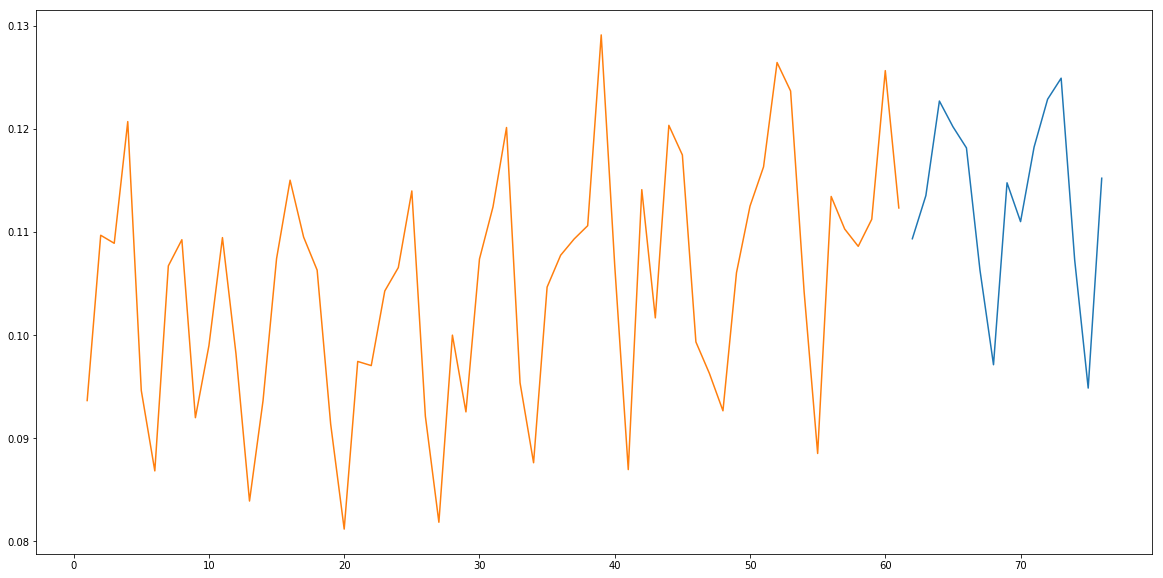

In [236]:
#Predict mean_demand for the next 14 days
mean_data = average_demand_prediction(df,1,61,62,76,order_param=(8,0,3),seasonal_param=(1,1,1,7))

In [280]:
#Prediction: mean_demand for the next 14 consecutive days 62 -> 76
mean_data

62    0.109346
63    0.113530
64    0.122701
65    0.120213
66    0.118155
67    0.106298
68    0.097127
69    0.114772
70    0.111005
71    0.118234
72    0.122875
73    0.124917
74    0.107300
75    0.094861
76    0.115215
dtype: float64

# USING THE MODEL

In [291]:
test_dataset= data[data['day']>55].drop(['demand'],axis=1)
test_dataset['day'] = test_dataset['day']+6
test_dataset.head(5)

,geohash6,day,timestamp
20,qp091w,62,10:0
22,qp09fu,63,18:30
26,qp09de,62,15:30
70,qp03w0,66,10:30
77,qp03xu,67,5:30


In [292]:
submission = predict_future_demand(test_dataset,model,mean_data)
submission.head(5)

,geohash6,day,timestamp,predict_demand
20,qp091w,62,10:0,0.067928
22,qp09fu,63,18:30,0.053790
26,qp09de,62,15:30,0.120444
70,qp03w0,66,10:30,0.113990
77,qp03xu,67,5:30,0.237556


# FINAL CONCLUSION